# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import re
import random
import warnings
warnings.simplefilter('ignore')
import calendar


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle, resample


from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb

1. Загружаю всё необходимое для проекта.
2. Исследую датафрейм.

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Итоги "первого взгляда":**

1. Есть пропущенные значения.
2. Дата создания и скачивания объявления, дата последнего визита пользователя, месяц регистрации и почтовый индекс скорее всего не пригодятся для исследований.
3. Большая часть признаков - категориальные. Из количественных - пройденный километраж, мощность двигателя. и скорее всего год регистрации.

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.describe(include=['object', 'bool'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


**Итоги "второго взгляда":**

1. Есть "странные" даты регистрации автомобилей
2. 150000 километров максимальный пробег автомобиля, возможно это ограничение сайта.
3. Странная кодитовка месяца регистрации.
4. Самая популярная машина Фольксваген Гольф.
5. Странные типы топлива, надо посмотреть.

In [7]:
total = df.isnull().sum().sort_values(ascending = False)
percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
pd.concat([total, percent], axis=1, keys=['Total','Percent']).style.background_gradient(cmap='Greens')

,Total,Percent
NotRepaired,71154,20.080000
VehicleType,37490,10.580000
FuelType,32895,9.280000
Gearbox,19833,5.600000
Model,19705,5.560000
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000


**Итоги "третьего взгляда":**
1. Не все отметили была ли машина в ремонте. При продаже это важно. Скорее всего, если не были, то человек просто ничего не отмечал, поэтому предположу, что нет, и тоже самое поставлю в таблице.
2. Тип автомобиля попробуем заполнить по марке и модели. Модель - по марке. Тип коробки - по году выпуска. Тип топлива - скорее всего, по модели.

Проработаю "странные" даты регистрации автомобилей. Форт Т - первый массовый автомобиль. Был выпущен в 1908 году, поэтому отсюда и буду смотреть. Всё таки они ещё продаются даже)

In [8]:
period = (df.query('RegistrationYear > 1908 and RegistrationYear < 2020')['RegistrationYear'].sort_values())
period

225468    1910
208755    1910
213796    1910
150021    1910
302641    1910
          ... 
30319     2019
165246    2019
332451    2019
62996     2019
37181     2019
Name: RegistrationYear, Length: 354198, dtype: int64

In [9]:
df_for_drop = np.round(100 - (len(period) * 100 / len(df)), 3)
print('% машин под удаление', df_for_drop)

% машин под удаление 0.048


1. % очень маленький, можно смело дропать.
2. Стоит отметить, что есть автомобили с нулевой ценой, но тут не знаю как их можно заполнить. Думаю пока оставить.

In [10]:
df = df.query('RegistrationYear > 1908 and RegistrationYear < 2020')

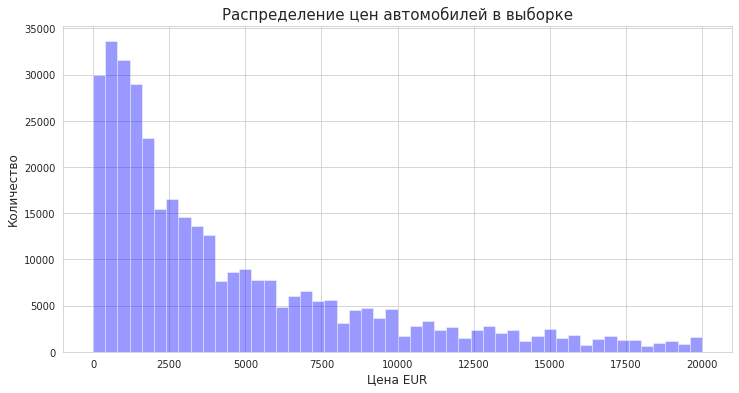

In [11]:
sns.set_style('whitegrid')

plt.figure(figsize=(12,6))
sns.distplot(df['Price'], kde=False, color='blue')

plt.xlabel('Цена EUR', size=12)
plt.ylabel('Количество', size=12)
plt.title('Распределение цен автомобилей в выборке', size=15);

Распределение цен находится в "адекватном" промежутке. Поэтому тут можно не переживать.

Приведу значения ч.м.д. к нормальному формату.

In [12]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
df['MonthCreated'] = df['DateCreated'].dt.weekday 
df['YearCreated'] = df['DateCreated'].dt.year  

In [13]:
df['MonthCreated'].value_counts()

0    63258
5    57003
1    51381
6    48821
2    47255
3    45530
4    40950
Name: MonthCreated, dtype: int64

Очень странно, что машины продаются только 7 месяцев в году. Скорее всего это баг на сайте объявлений. Что то с этим сделать в проекте врят ли возможно.

In [14]:
temp = df.groupby('MonthCreated')['Price'].median()
temp.head()

MonthCreated
0    2700
1    2500
2    2600
3    2650
4    2750
Name: Price, dtype: int64

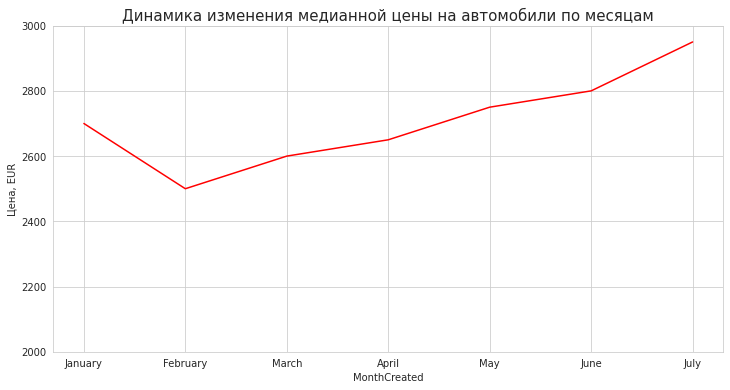

In [15]:
plt.figure(figsize=(12,6))
sns.lineplot(data=temp, color='red')
plt.ylim(2000,3000)
plt.xticks(np.arange(7), calendar.month_name[1:8])
plt.ylabel('Цена, EUR')
plt.title('Динамика изменения медианной цены на автомобили по месяцам', size=15);

Самые "дешевые" автомобили в феврале, самые "дорогие" в июле.

Теперь проверю распределение объявлений по годам.

In [16]:
temp = df.groupby('YearCreated')['Price'].agg(['median', 'count']).reset_index()
temp.head()

,YearCreated,median,count
0,2014,8999,1
1,2015,6000,25
2,2016,2700,354172


В 2014 году выставлена на продажу всего одна машина, в 2015 -  25 машин, в 2016 - 99% всей выборки. Сложно объяснить, возможно сайт был совсем не популярен в 2014 году. Оставлю как есть.

### Заполнение пропусков

**Ремонт автомобиля**

In [17]:
not_rem = df.loc[df['NotRepaired'].isna()]['RegistrationYear'].value_counts()
not_rem_perc = not_rem.head(10).sum() / df.loc[df['NotRepaired'].isna(), 'Price'].count()

print(not_rem.head(10))
print()
print('Автомобили без указания ремонта, составляют {:.2%} от общего количества'.format((not_rem_perc)))

2000    7286
1999    4849
2017    4594
2005    4452
2016    4426
1998    4074
2001    3616
1997    3571
1995    3328
2002    3160
Name: RegistrationYear, dtype: int64

Автомобили без указания ремонта, составляют 61.06% от общего количества


Как указывал выше, все пропущенные значения здесь заполню строкой 'no'.
Все автомобили, без указания ремонта можно сказать новые. Скорее всего, тут учитывается именно ремонт после ДТП, поэтому заполню как и указал.

In [18]:
df['NotRepaired'] = df['NotRepaired'].fillna(value='no')
df['NotRepaired'].head()

0     no
1    yes
2     no
3     no
4     no
Name: NotRepaired, dtype: object

**Коробка передач**

In [19]:
df['Gearbox'].head()

0    manual
1    manual
2      auto
3    manual
4    manual
Name: Gearbox, dtype: object

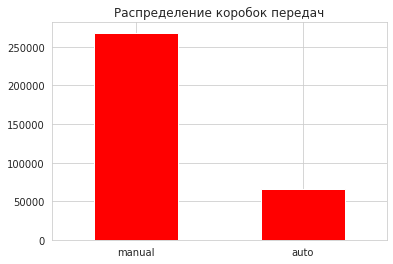

In [20]:
plt.figure()
df['Gearbox'].value_counts().plot(kind='bar', color='red')
plt.xticks(rotation=0)
plt.title('Распределение коробок передач');

Ручных коробок передач практически в 5 раз больше

In [21]:
df['GearboxUnsorted'] = df['Gearbox'].fillna(value='unsorted')
df['Gearbox'] = df['Gearbox'].fillna('manual')

Сделаю 2 столбца, один будет с неотсортированными коробками, второй с заполненными пустыми значениями на ручную коробку,посмотрю, с какми значениями будет лучше работать модель машинного обучения, хотя можно было бы заморочиться, посмотреть подробнее пропуски и прописать для конкретных моделей, но данных оказалось много, поэтому не буду тратить время, на цену вроде как сильно не влияет.

**Модель автомобиля**

In [22]:
temp = pd.DataFrame(df.groupby(['Brand'])['Model'].count()).reset_index()

temp.sort_values(by='Model', ascending=False).tail()

,Brand,Model
13,jaguar,491
17,lancia,448
28,rover,404
16,lada,210
33,sonstige_autos,0


sonstige_autos переводчик перевел как "Другие автомобили". Видимо моделей таких авто на сайте нет. Для удобства запихну их в other

In [23]:
len(df.query('Brand == "sonstige_autos"'))

3338

In [24]:
len(df.loc[df['Model']=="other"])

24403

In [25]:
df.loc[df['Brand']=='sonstige_autos', 'Model'] = df.loc[df['Brand']=='sonstige_autos', 'Model'].fillna('other')

In [26]:
len(df.loc[df['Model']=="other"])

27741

In [27]:
df['Model'].isna().sum()

16292

Пропуски, как и писал выше, заполню на основе лямбда функции самыми частыми представителями брендов.

In [28]:
mod_dict = df.groupby(['Brand'])['Model'].apply(lambda x: x.mode()[0])

df['Model'] = df['Model'].fillna(df['Brand'].map(mod_dict))

In [29]:
df['Model'].isna().sum()

0

In [30]:
df.isna().sum().sort_values()

DateCrawled              0
MonthCreated             0
LastSeen                 0
PostalCode               0
NumberOfPictures         0
DateCreated              0
NotRepaired              0
Brand                    0
YearCreated              0
GearboxUnsorted          0
Kilometer                0
Model                    0
Power                    0
Gearbox                  0
RegistrationYear         0
Price                    0
RegistrationMonth        0
FuelType             32767
VehicleType          37319
dtype: int64

**Модель кузова**

In [31]:
vt_dict = dict(df.groupby(['Model'])['VehicleType'].apply(lambda x: x.mode()[0]))

df['VehicleType'] = df['VehicleType'].fillna(df['Model'].map(vt_dict))

Проделал тоже самое, на основе лямбда функции.

In [32]:
df.isna().sum().sort_values()

DateCrawled              0
MonthCreated             0
LastSeen                 0
PostalCode               0
NumberOfPictures         0
DateCreated              0
NotRepaired              0
Brand                    0
YearCreated              0
GearboxUnsorted          0
Kilometer                0
Model                    0
Power                    0
Gearbox                  0
RegistrationYear         0
VehicleType              0
Price                    0
RegistrationMonth        0
FuelType             32767
dtype: int64

**Тип топлива**

In [33]:
df['FuelType'].value_counts()

petrol      216318
gasoline     98713
lpg           5310
cng            564
hybrid         233
other          203
electric        90
Name: FuelType, dtype: int64

Типы топлива адекватные, поэтому спасаемся от пропусков великой лямбда функцией.

In [34]:
fuel_dict = df.groupby(['Model'])['FuelType'].apply(lambda x: x.mode()[0])

np.unique(fuel_dict.values)

array(['gasoline', 'petrol'], dtype=object)

In [35]:
df['FuelType'].isna().sum()

32767

In [36]:
df['FuelType'] = df['FuelType'].fillna(df['Model'].map(fuel_dict))

In [37]:
df['FuelType'].isna().sum()

0

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354198 non-null  object        
 1   Price              354198 non-null  int64         
 2   VehicleType        354198 non-null  object        
 3   RegistrationYear   354198 non-null  int64         
 4   Gearbox            354198 non-null  object        
 5   Power              354198 non-null  int64         
 6   Model              354198 non-null  object        
 7   Kilometer          354198 non-null  int64         
 8   RegistrationMonth  354198 non-null  int64         
 9   FuelType           354198 non-null  object        
 10  Brand              354198 non-null  object        
 11  NotRepaired        354198 non-null  object        
 12  DateCreated        354198 non-null  datetime64[ns]
 13  NumberOfPictures   354198 non-null  int64   

**Избавление от дубликантов**

In [39]:
df = df.drop_duplicates()

Дропнул дубликанты.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354193 entries, 0 to 354368
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354193 non-null  object        
 1   Price              354193 non-null  int64         
 2   VehicleType        354193 non-null  object        
 3   RegistrationYear   354193 non-null  int64         
 4   Gearbox            354193 non-null  object        
 5   Power              354193 non-null  int64         
 6   Model              354193 non-null  object        
 7   Kilometer          354193 non-null  int64         
 8   RegistrationMonth  354193 non-null  int64         
 9   FuelType           354193 non-null  object        
 10  Brand              354193 non-null  object        
 11  NotRepaired        354193 non-null  object        
 12  DateCreated        354193 non-null  datetime64[ns]
 13  NumberOfPictures   354193 non-null  int64   

**Мощность двигателя**

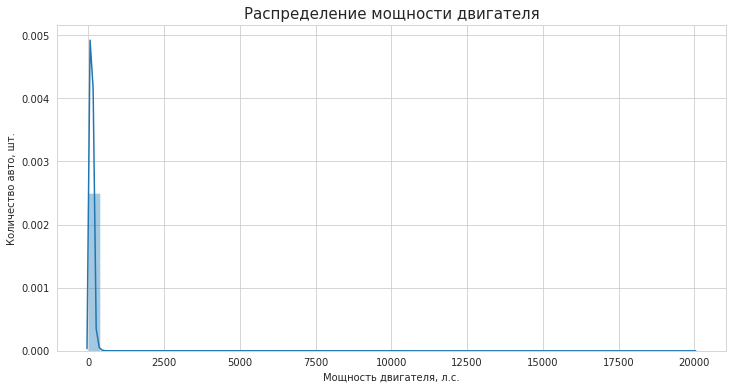

In [41]:
plt.figure(figsize=(12,6))
sns.distplot(df['Power'])
plt.xlabel('Мощность двигателя, л.с.')
plt.ylabel('Количество авто, шт.')
plt.title('Распределение мощности двигателя',size=15);

Есть нулевые значения и очень большие. Сомневаюсь, что там ядерный двигатель)

In [42]:
df.query('Power > 400')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,MonthCreated,YearCreated,GearboxUnsorted
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26,1,2016,manual
2102,2016-03-21 11:55:22,0,sedan,1999,manual,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06,0,2016,unsorted
2781,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16,0,38448,2016-04-01 22:47:31,2,2016,auto
3289,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10,0,44319,2016-04-03 18:47:41,3,2016,auto
3746,2016-03-21 14:48:31,0,small,2017,manual,750,fortwo,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59,0,2016,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353493,2016-04-02 20:54:21,12500,sedan,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02,0,44145,2016-04-06 21:44:39,5,2016,manual
353633,2016-03-23 23:55:21,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,no,2016-03-23,0,45277,2016-03-27 01:15:17,2,2016,manual
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22,0,38118,2016-03-24 05:16:02,1,2016,auto
354260,2016-03-09 17:59:03,399,other,1994,manual,1103,3er,150000,0,petrol,bmw,no,2016-03-09,0,56235,2016-03-17 09:17:08,2,2016,unsorted


Видно приличное число очень больших значений. Если например, для Е-Класса, Порша Кайен ещё верю, то вектра и королла врят ли чипуются до 1400 л/с. Всё таки не Бугатти Широн) Напишу функцию, чтобы снизить на порядок эти значения, чтобы влезть в нормальный интервал. Предлагаю от 600 до 5000 поделить на 10, от 5000 и выше на 100, тогда значения будут приемлемы.

In [43]:
def norm_power(row):
    
    power = row['Power']
    
    if 600 <= power <= 5000:
        return power / 10
    if 5001 <= power <= 9999:
        return power / 100
    if power < 50:
        return np.nan
    else:
        return power

In [44]:
df['Power_norm'] = df.apply(norm_power, axis=1)

In [45]:
df['Power_norm'].isna().sum()

46040

In [46]:
df = df.drop(df.loc[df['Power']>=10000].index)

In [47]:
df['Power_norm'] = df.groupby('Model')['Power_norm'].transform(lambda x: x.fillna(value=x.median()))
print('Пропуски значений мощности', df['Power_norm'].isna().sum())
print('Нулевая мощность', len(df[df['Power_norm']==0]))

Пропуски значений мощности 2
Нулевая мощность 0


In [48]:
df = df.drop(df[df['Power_norm'].isna()].index)
df['Power_norm'] = df['Power_norm'].astype('int')
print('Пропуски значений', df['Power_norm'].isna().sum())

Пропуски значений 0


На "всякий случай" столбец не переписываю, а создам новый с более нормальными значениями мощности. Ну и соответственн избавлю его от пропусков.

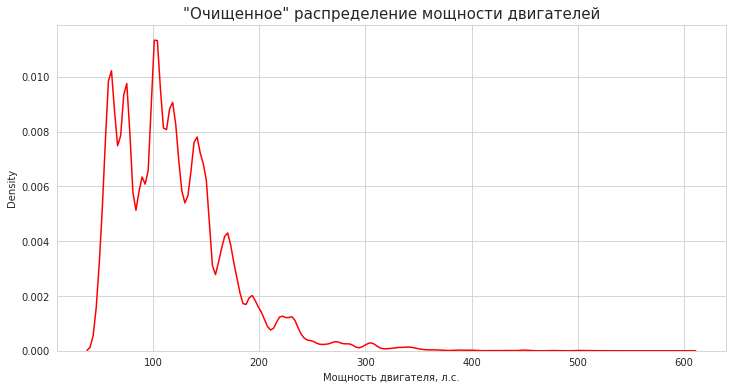

In [49]:
plt.figure(figsize=(12,6))

sns.distplot(df['Power_norm'], color='red', hist=False)

plt.xlabel('Мощность двигателя, л.с.')
plt.title('"Очищенное" распределение мощности двигателей',size=15);

In [50]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
MonthCreated         0
YearCreated          0
GearboxUnsorted      0
Power_norm           0
dtype: int64

In [51]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354146 entries, 0 to 354368
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354146 non-null  object        
 1   price              354146 non-null  int64         
 2   vehicletype        354146 non-null  object        
 3   registrationyear   354146 non-null  int64         
 4   gearbox            354146 non-null  object        
 5   power              354146 non-null  int64         
 6   model              354146 non-null  object        
 7   kilometer          354146 non-null  int64         
 8   registrationmonth  354146 non-null  int64         
 9   fueltype           354146 non-null  object        
 10  brand              354146 non-null  object        
 11  notrepaired        354146 non-null  object        
 12  datecreated        354146 non-null  datetime64[ns]
 13  numberofpictures   354146 non-null  int64   

Пропуков нет, названия столбцов перевел в нижний регистр (хотя это следовало бы сделать вначале).

**Вывод 1 раздела**
1. Проведен анализ, предобработка данных и подготовка к машинному обучению.
2. Были обнаружены странные показатели датафрейма, которые сложно как то обработать и объяснить (тут нужно работать с поставщиком данных)
3. Были исключены все обнаруженные пропуски, в основном с помощью лямбда функции.

Предобработка и анализ данных завершены, можно переходить к обучению моделей.

## Обучение моделей

Первым делом стоит удалить признаки, не влияющие на обучение моделей и разбить выборки на обучающую и тестовую.

In [52]:
drop_col = ['price', 'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen', 'monthcreated', 'yearcreated', 'gearboxunsorted', 'power']

features = df.drop(drop_col, axis=1)
target = df['price']

In [53]:
features.head()

,vehicletype,registrationyear,gearbox,model,kilometer,fueltype,brand,notrepaired,power_norm
0,sedan,1993,manual,golf,150000,petrol,volkswagen,no,101
1,coupe,2011,manual,a4,125000,gasoline,audi,yes,190
2,suv,2004,auto,grand,125000,gasoline,jeep,no,163
3,small,2001,manual,golf,150000,petrol,volkswagen,no,75
4,small,2008,manual,fabia,90000,gasoline,skoda,no,69


In [54]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [55]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=12345)

In [56]:
print(x_train.shape[0], x_valid.shape[0], x_test.shape[0])

212487 70829 70830


Разбил выборки на обучающую, валидационнубю и тестовую

### DummyRegressor

In [57]:
%%time

dummy = DummyRegressor(strategy='mean')

dummy.fit(x_train, y_train)
y_pred = dummy.predict(x_valid)

rmse_dr = np.around(np.sqrt(mean_squared_error(y_valid, y_pred)),5)
print('RMSE дамми регрессора со средним прогнозом цен = {}'.format(rmse_dr))
print()

RMSE дамми регрессора со средним прогнозом цен = 4505.27495

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 2.91 ms


Ошибка достаточно велика, зато считает очень быстро

### Rmse метрика

На данном шаге осуществлю подбор гиперпараметров и зафиксирую лучшее значение метрики RMSE.

In [58]:
def rmse(targets, predictions):
    return np.sqrt(((predictions - targets) ** 2).mean())

RMSE_SCORE = make_scorer(rmse, greater_is_better=False)

Написал фунсцию скоринга МСЕ

In [59]:
features_ = pd.get_dummies(features, drop_first=True)
target_ = df['price'] 

x_train_val, x_test_, y_train_val, y_test_ = train_test_split(features_, target_, test_size=0.2, random_state=12345)
x_train_, x_valid_, y_train_, y_valid_ = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=12345)

print(x_train_.shape[0], x_valid_.shape[0], x_test_.shape[0])

212487 70829 70830


<div class="alert alert-warning">
<b>Комментарий от ревьюера v1</b>
    
<b>Рекомендация:</b> Почти незаметно ты используешь OHE, но тут нужно подумать, правильно ли использовать OHE на таком признаке, как model. Он добавит 250+ столбцов содержащих в основном одни нули) Я бы рекомендовал следовать такой логике:
   
- Если в признаке мало уникальных значений, то OHE;
- Если много, то нужно думать. Так ли нам нужен этот признак, может можно его как-то укрупнить(например перевести в класс машин). Есть ли возможность использовать другую кодировку, например TargetEncoder;
- Если мы используем модели, которые сами умеют работать с категориальными признаками(lgbm, catboost), то отдать им это на откуп)
</div>


Нашел гиперпараметры на основе регрессора

In [60]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=12345)

dtr_params = dict(max_depth=[5,6,7], 
                 max_features=[2,3,4])

In [61]:
def rand_search(model, grid, feat, targ):
    
    search = RandomizedSearchCV(model, grid, cv=5, scoring=RMSE_SCORE, n_jobs=-1)
    search.fit(feat, targ)
    
    print(search.best_score_ * -1)
    print(search.best_params_)

<div class="alert alert-warning">
<b>Комментарий от ревьюера v1</b>
    
<b>Рекомендация:</b> А зачем тут использовать функцию, если внутри вызывается RandomizedSearchCV? Получается, что мы оптимизируем вызов метода fit(), но теряем возможность использовать дальше нашу модель
</div>


Написал функцию рандомного поиска гиперпараметров

In [62]:
rand_search(dtr, dtr_params, x_train_, y_train_)

4290.654077736544
{'max_features': 3, 'max_depth': 7}


In [63]:
def rmse_score(model, x, y):
    
    y_pred = model.predict(x)

    score = rmse(y, y_pred)
    
    return(score)

In [64]:
dtr = DecisionTreeRegressor(random_state=12345, max_features=3, max_depth=7)

dtr.fit(x_train_, y_train_)

print('Валидационная выборка', rmse_score(dtr, x_valid_, y_valid_))
print('Тестовая выборка', rmse_score(dtr, x_test_, y_test_))

Валидационная выборка 4252.434509482249
Тестовая выборка 4269.7958513278245


Скоринг работает, но ошибка достаточно велика. Но уже лучше чем дамми модель.

### XGBoost

In [65]:
dtrain = xgb.DMatrix(x_train_, label=y_train_)
dval = xgb.DMatrix(x_valid_)
dtest = xgb.DMatrix(x_test_)

In [66]:
%%time
param = {'max_depth':3, 
         'eta':1, 
         'sampling_method':'gradient_based', 
         'verbosity':1, 
         'gamma':10, 
         'seed':12345}

num_round = 30

bst = xgb.train(param, dtrain, num_round)

CPU times: user 1min 42s, sys: 513 ms, total: 1min 43s
Wall time: 1min 43s


Обучение происходит достаточно быстро. Всего 1 минута

In [67]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 2079.646843743193

CPU times: user 837 ms, sys: 0 ns, total: 837 ms
Wall time: 862 ms


In [68]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 2078.6405910881317

CPU times: user 326 ms, sys: 0 ns, total: 326 ms
Wall time: 317 ms


Учится достаточно быстро и показывает хороший результат, поработаю над параметрами, чтобы улучшить модель

In [69]:
%%time
param = {'max_depth':6, 
         'eta':0.5, 
         'min_child_weight':4,
         'sampling_method':'gradient_based', 
         'verbosity':1,  
         'seed':12345}

num_round = 35

bst = xgb.train(param, dtrain, num_round)

CPU times: user 3min 51s, sys: 0 ns, total: 3min 51s
Wall time: 3min 52s


In [70]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 1853.9930490964127

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 994 ms


In [71]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 1907.827499549179

CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 310 ms


Путем подбора параметров улучшил значение RMSE, но заметно увеличилось время.

### LightGBM

Путем изучения библиотеки, понял, что категориальные признаки необходимо перевести из int в str

In [72]:
features_light = features.copy()

In [73]:
features.head()

,vehicletype,registrationyear,gearbox,model,kilometer,fueltype,brand,notrepaired,power_norm
0,sedan,1993,manual,golf,150000,petrol,volkswagen,no,101
1,coupe,2011,manual,a4,125000,gasoline,audi,yes,190
2,suv,2004,auto,grand,125000,gasoline,jeep,no,163
3,small,2001,manual,golf,150000,petrol,volkswagen,no,75
4,small,2008,manual,fabia,90000,gasoline,skoda,no,69


In [74]:
features_light.columns

Index(['vehicletype', 'registrationyear', 'gearbox', 'model', 'kilometer',
       'fueltype', 'brand', 'notrepaired', 'power_norm'],
      dtype='object')

In [75]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [76]:
cat_feat = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

features_light[cat_feat] = enc.fit_transform(features_light[cat_feat]).astype('int')

In [77]:
features_light.head()

,vehicletype,registrationyear,gearbox,model,kilometer,fueltype,brand,notrepaired,power_norm
0,4,1993,1,116,150000,6,38,0,101
1,2,2011,1,29,125000,2,1,1,190
2,6,2004,0,117,125000,2,14,0,163
3,5,2001,1,116,150000,6,38,0,75
4,5,2008,1,101,90000,2,31,0,69


Создам 3 выборки и укажу для них первичные параметры

In [78]:
x_train_val_l, x_test_l, y_train_val_l, y_test_l = train_test_split(features_light, target, test_size=0.2, random_state=12345)

x_train_l, x_valid_l, y_train_l, y_valid_l = train_test_split(x_train_val_l, y_train_val_l, test_size=0.25, random_state=12345)

print(x_train_l.shape[0], x_valid_l.shape[0], x_test_l.shape[0])

212487 70829 70830


In [79]:
train_data = lgb.Dataset(x_train_l, y_train_l, categorical_feature=cat_feat)
valid_data = lgb.Dataset(x_valid_l, categorical_feature=cat_feat) 
test_data = lgb.Dataset(x_test_l, categorical_feature=cat_feat)

In [80]:
#params = {
#    'boosting_type': 'gbdt',
#    'objective': 'regression',
#    'num_leaves': 127,
#    'min_data_in_leaf':100,
#    'metric':'rmse',
#    'learning_rate': 1,
#    'verbose': 1
#}

In [81]:
#%%time
#gbm = lgb.train(params,train_data,num_boost_round=30)

In [82]:
#%%time
#print('RMSE на обучающей выборке', rmse_score(gbm, x_train_l, y_train_l))
#print()

In [83]:
#%%time
#print('RMSE на валидационной выборке', rmse_score(gbm, x_valid_l, y_valid_l))
#print()

In [84]:
params_upd = {
    'boosting_type': 'gbdt',
    'tree_learner':'feature',
    'objective': 'regression',
    #'max_depth':12,
    'num_leaves': 300,
    #'min_data_in_leaf':300,
    'max_bin':100,
    'learning_rate': 0.35,
    'num_iteration':150,
    'metric':'rmse',
    'verbose': 1
}

In [85]:
%%time
gbm = lgb.train(params_upd,
                train_data,
                num_boost_round=45)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 212487, number of used features: 9
[LightGBM] [Info] Start training from score 4415.729282
CPU times: user 3min 24s, sys: 1.51 s, total: 3min 25s
Wall time: 3min 27s


In [86]:
%%time
print('RMSE на обучающей выборке', rmse_score(gbm, x_train_l, y_train_l))
print()

RMSE на обучающей выборке 1327.3640118644223

CPU times: user 7.53 s, sys: 163 µs, total: 7.53 s
Wall time: 7.52 s


In [87]:
%%time
print('RMSE на валидационной выборке', rmse_score(gbm, x_valid_l, y_valid_l))
print()

RMSE на валидационной выборке 1759.0506995317473

CPU times: user 2.58 s, sys: 7.96 ms, total: 2.59 s
Wall time: 2.59 s


Модель переобучена, но скорость обучения и rmse на валидационной выборке лучше предыдущей модели.

### Catboost

In [88]:
x_train_val_c, x_test_c, y_train_val_c, y_test_c = train_test_split(features, target, test_size=0.2, random_state=12345)

x_train_c, x_valid_c, y_train_c, y_valid_c = train_test_split(x_train_val_c, y_train_val_c, test_size=0.25, random_state=12345)

print(x_train_c.shape[0], x_valid_c.shape[0], x_test_c.shape[0])

212487 70829 70830


In [89]:
x_train_c.columns

Index(['vehicletype', 'registrationyear', 'gearbox', 'model', 'kilometer',
       'fueltype', 'brand', 'notrepaired', 'power_norm'],
      dtype='object')

Также создам 3 пула и обучу модель

In [90]:
train_pool = Pool(x_train_c, y_train_c, cat_features=cat_feat)

valid_pool = Pool(x_valid_c, y_valid_c, cat_features=cat_feat)

test_pool = Pool(x_test_c, cat_features=cat_feat) 

In [91]:
cbr = CatBoostRegressor(depth=6, 
                        learning_rate=1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        random_state=12345, 
                        iterations=500)

In [92]:
%%time
cbr.fit(train_pool)

0:	learn: 2772.0562260	total: 542ms	remaining: 4m 30s
50:	learn: 1870.9791852	total: 18.7s	remaining: 2m 45s
100:	learn: 1800.1242536	total: 36.4s	remaining: 2m 23s
150:	learn: 1759.9443803	total: 54.5s	remaining: 2m 5s
200:	learn: 1731.3720985	total: 1m 12s	remaining: 1m 47s
250:	learn: 1706.9273628	total: 1m 29s	remaining: 1m 29s
300:	learn: 1686.4999298	total: 1m 47s	remaining: 1m 11s
350:	learn: 1671.2900018	total: 2m 5s	remaining: 53.5s
400:	learn: 1652.8612378	total: 2m 22s	remaining: 35.3s
450:	learn: 1638.9953538	total: 2m 41s	remaining: 17.5s
499:	learn: 1626.7894915	total: 2m 59s	remaining: 0us
CPU times: user 2min 59s, sys: 571 ms, total: 2min 59s
Wall time: 3min 3s


In [93]:
%%time
print('RMSE на обучающей выборке', rmse_score(cbr, x_train_c, y_train_c))
print()

RMSE на обучающей выборке 1657.6878359599077

CPU times: user 1.54 s, sys: 8.15 ms, total: 1.54 s
Wall time: 1.65 s


In [94]:
%%time
print('RMSE на валидационной выборке', rmse_score(cbr, x_valid_c, y_valid_c))
print()

RMSE на валидационной выборке 1850.702621650563

CPU times: user 518 ms, sys: 4.06 ms, total: 522 ms
Wall time: 534 ms


Попробую ещё "поиграться с параметрами"

In [95]:
cbr_1 = CatBoostRegressor(depth=7, 
                        learning_rate=0.1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        l2_leaf_reg=10,
                        random_state=12345, 
                        iterations=400)

In [96]:
%%time
cbr_1.fit(train_pool)

0:	learn: 4225.8760595	total: 561ms	remaining: 3m 43s
50:	learn: 2024.3205520	total: 22.4s	remaining: 2m 33s
100:	learn: 1936.2533428	total: 43.4s	remaining: 2m 8s
150:	learn: 1890.6657482	total: 1m 4s	remaining: 1m 45s
200:	learn: 1863.2572332	total: 1m 24s	remaining: 1m 23s
250:	learn: 1843.4483078	total: 1m 44s	remaining: 1m 2s
300:	learn: 1826.1585462	total: 2m 4s	remaining: 41s
350:	learn: 1809.3273618	total: 2m 25s	remaining: 20.2s
399:	learn: 1797.6936545	total: 2m 46s	remaining: 0us
CPU times: user 2min 44s, sys: 470 ms, total: 2min 45s
Wall time: 2min 49s


In [97]:
%%time
print('RMSE на обучающей выборке', rmse_score(cbr_1, x_train_c, y_train_c))
print()

RMSE на обучающей выборке 1794.9669176356472

CPU times: user 1.04 s, sys: 11.8 ms, total: 1.05 s
Wall time: 1.05 s


In [98]:
%%time
print('RMSE на валидационной выборке', rmse_score(cbr_1, x_valid_c, y_valid_c))
print()

RMSE на валидационной выборке 1841.9804023597665

CPU times: user 327 ms, sys: 4.13 ms, total: 331 ms
Wall time: 343 ms


Удалось немного улучшить RMSE

**Вывод:**
В исследовании приняли участие 3 модели : 'LightGBM', 'Catboost', 'xgboost'
Основной метрикой тестрирования стал корень среднеквадратичной ошибки.
Наилучшей и рекомендованной к использованию моделью считаю LightGBM, т.к. она показала оптимальные результаты по отношению к остальным.

## Анализ моделей

Для анализа моделей стоит определить метрику RMSE на тестовой выборке

In [102]:
%%time
print('RMSE xgboost на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE xgboost на валидационной выборке 1907.827499549179

CPU times: user 31.7 ms, sys: 66 µs, total: 31.8 ms
Wall time: 9.61 ms


In [103]:
%%time
print('RMSE LightGBM на валидационной выборке', rmse_score(gbm, x_valid_l, y_valid_l))
print()

RMSE LightGBM на валидационной выборке 1759.0506995317473

CPU times: user 2.75 s, sys: 0 ns, total: 2.75 s
Wall time: 2.67 s


In [104]:
%%time
print('RMSE CatBoost на валидационной выборке', rmse_score(cbr_1, x_valid_c, y_valid_c))
print()

RMSE CatBoost на валидационной выборке 1841.9804023597665

CPU times: user 350 ms, sys: 0 ns, total: 350 ms
Wall time: 362 ms


In [105]:
%%time
print('RMSE лучшей модели на тестовой выборке', rmse_score(gbm, x_test_l, y_test_l))
print()

RMSE лучшей модели на тестовой выборке 1760.0102349081576

CPU times: user 2.68 s, sys: 4.94 ms, total: 2.68 s
Wall time: 2.62 s


## Общий вывод проекта

1. Произведен анализ и подготовка данных датасета. 
2. В исследовании использовались 3 модели : 'LightGBM', 'Catboost', 'xgboost'
3. Основной метрикой тестрирования стал корень среднеквадратичной ошибки.
4. Наилучшей и рекомендованной к использованию моделью признана LightGBM.
5. Изучение и тестирование моделей градиентного бустинга - успешно выполнены.